In [1]:
import sys
import os

sys.path.append('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/training')


In [2]:
import pandas as pd
import numpy as np
import torch 
from torch import from_numpy
import torch.nn as nn
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tl_tools import *
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [3]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))

X_test, y_test = test_splits(test)

class_labels = list(test.class_indices.keys())

X_test = from_numpy(X_test.numpy()).permute(0, 3, 1, 2)
y_test = from_numpy(y_test.numpy())

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245



2024-11-19 13:23:08.460464: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-19 13:23:08.460494: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-19 13:23:08.460501: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-19 13:23:08.460516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-19 13:23:08.460559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [4]:
convnext = convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)
convnext.classifier = nn.Sequential(
    nn.Flatten(),     
    
    #FC 1                       
    nn.Linear(in_features=768, out_features=64),   
    nn.ReLU(),
    nn.BatchNorm1d(64), 
    nn.Dropout1d(p=0.3), 
           
    #FC 2                                           
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(), 
    nn.BatchNorm1d(32),  
    nn.Dropout1d(p=0.3), 
    
    #Softmax
    nn.Linear(in_features=32, out_features=6),  
    nn.Softmax(dim=1)                                           
)


for param in convnext.features.parameters(): 
    param.requires_grad = False

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
convnext = convnext.to(device)

# Load the saved weights
checkpoint = torch.load('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/convnext_model.pth', weights_only=False)
convnext.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
true_labels = list()
with torch.no_grad():
    for _, targets in test_loader:
        true_labels.extend(torch.argmax(targets, dim=1).numpy())
true_labels = np.array(true_labels)

In [6]:
# Create feature extractor model
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        return x.view(x.size(0), -1)  # Flatten the output

# Create feature extractor
feature_extractor = FeatureExtractor(convnext)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()  # Set to evaluation mode

# Extract features
features = []
with torch.no_grad():
    for inputs, _ in test_loader:  # We don't need the labels here
        inputs = inputs.to(device)
        batch_features = feature_extractor(inputs)
        features.extend(batch_features.cpu().numpy())

feature_extractor_pred = np.array(features)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_extractor_pred = scaler.fit_transform(feature_extractor_pred)
feature_extractor_df = pd.DataFrame(feature_extractor_pred)
y_true_series = pd.Series(true_labels)

class_mapping = dict()
for i, label in enumerate(class_labels): 
    class_mapping[i] = label

y_true_labels = y_true_series.map(class_mapping)

In [8]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(feature_extractor_df, y_true_series)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [9]:
feature_importances = pd.Series(xgb.feature_importances_).sort_values(ascending= False)
n_features = len(feature_importances)
print(f'Number of features: {n_features:,}')

percentage_5 = feature_importances.head((n_features // 20)).sum()
percentage_10 = feature_importances.head((n_features // 10)).sum()
percentage_25 = feature_importances.head((n_features // 4)).sum()

print(f'Cumulative feature importance of 5% of the extracted features: {(percentage_5 * 100):.2f}%')
print(f'Cumulative feature importance of 10% of the extracted features: {(percentage_10 * 100):.2f}%')
print(f'Cumulative feature importance of 25% of the extracted features: {(percentage_25 * 100):.2f}%')

Number of features: 768
Cumulative feature importance of 5% of the extracted features: 33.67%
Cumulative feature importance of 10% of the extracted features: 45.93%
Cumulative feature importance of 25% of the extracted features: 69.25%


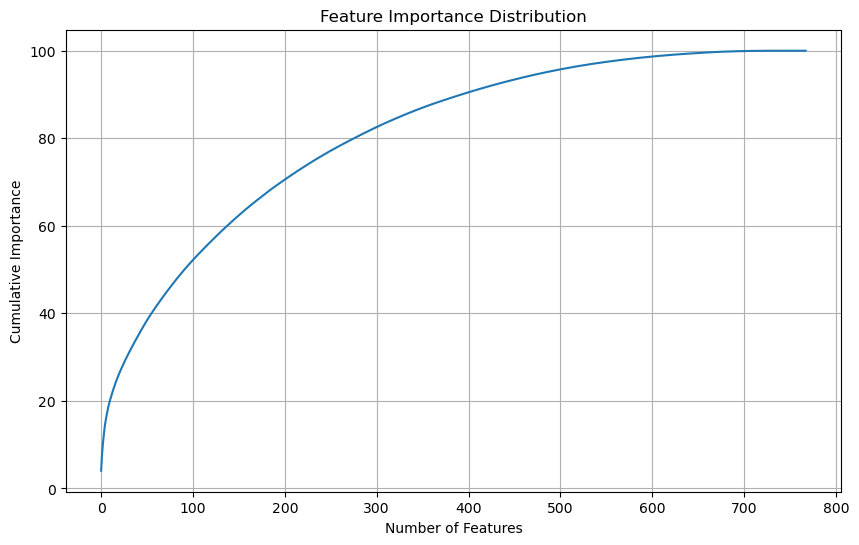

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(feature_importances)), feature_importances.cumsum() * 100)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Feature Importance Distribution')
plt.grid(True)

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state= 1, perplexity= 30, max_iter = 2000, learning_rate= 'auto', init = 'pca')
X_tsne = tsne.fit_transform(feature_extractor_df)
tsne_df = pd.DataFrame(data = {
    'x1': X_tsne[:, 0], 
    'x2': X_tsne[:, 1], 
    'class': y_true_series
})

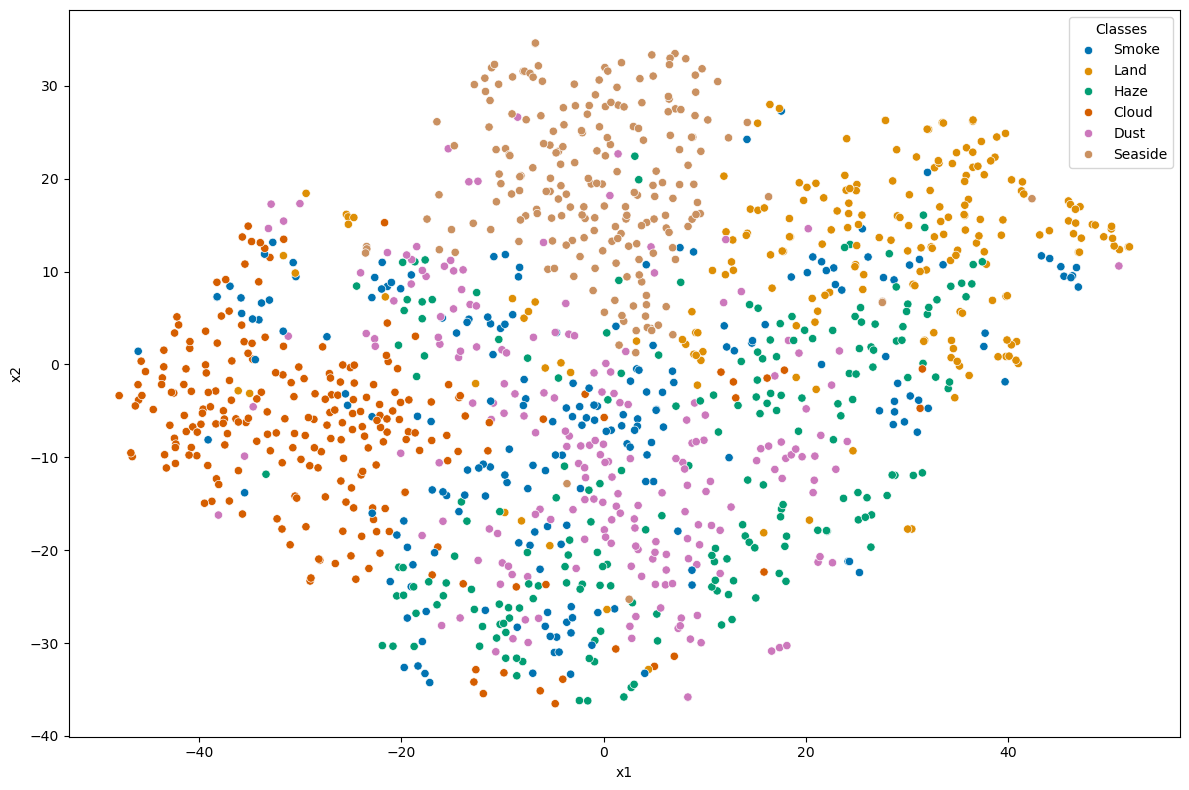

In [12]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize= (12, 8))
scatter = sns.scatterplot(x = 'x1', y = 'x2', data = tsne_df, hue = y_true_labels, palette = 'colorblind')
scatter.legend(title = 'Classes')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

features = tsne_df[['x1','x2']]

silhouette_scores = list()
davies_scores = list()

for n in range(10): 
    kmeans = KMeans(n_clusters=6, max_iter=1500, random_state= n, n_init = 10)
    cluster_labels = kmeans.fit_predict(features)

    silhouette_scores.append(silhouette_score(features, cluster_labels))
    davies_scores.append(davies_bouldin_score(features, cluster_labels))

silhouette_mean = np.mean(silhouette_scores)
silhouette_std = np.std(silhouette_scores)
davies_mean = np.mean(davies_scores)
davies_std = np.std(davies_scores)

print(f'Mean Silhouette Score: {silhouette_mean:.4f} (± {silhouette_std:.4f})')
print(f'Mean Davies-Boulding Score: {davies_mean:.4f} (± {davies_std:.4f})')

Mean Silhouette Score: 0.3951 (± 0.0041)
Mean Davies-Boulding Score: 0.8345 (± 0.0191)
